# Examining if the k-corrections are introducing bias in our data.

In [1]:
from astropy.table import Table, join
from astropy.cosmology import Planck18, LambdaCDM, FlatLambdaCDM
from astropy.coordinates import Distance
from astropy.io import fits
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

import numpy as np

from scipy.stats import binned_statistic

import pickle

import os

import matplotlib.pyplot as plt

# Custom functions / classes
import sys
sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

# Data

In [2]:
h = 1
H0 = 100*h

c = const.c.to('km/s')
q0 = 0.2

In [3]:
# SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_VI.fits')
SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')
# SGA_TF = Table.read('SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.365240555641251e-05,122.32238811543634,9.671537005812278,N
55,SGA-2020 55,PGC120394

### Load in morphological classifications

In [4]:
# ai_morphpath = '.'
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)

# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

SGA_TF = join(SGA_TF, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
SGA_TF['Predicted_Type'].name = 'MORPHTYPE_AI'

### Apply VI

In [5]:
lucey_VIpath = 'VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'

SGA_TF = join(SGA_TF, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
SGA_TF['VI'].name = 'JOHN_VI'

### Convert to CMB frame

In [6]:
SGA_TF['Z_DESI_CMB'] = convert_z_frame(SGA_TF['Z_DESI'], SGA_TF['RA'], SGA_TF['DEC'])

### Apply photometric corrections

In [7]:
# Survey offsets

sys_corr, sys_corr_err = BASS_corr(SGA_TF['PHOTSYS'])

In [8]:
#### Milky Way dust corrections

# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

MWdust_corr, MWdust_corr_err = MW_dust(SGA_TF['RA'], SGA_TF['DEC'], ebv_map)

# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

/global/u1/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


### Determine k-corrections and internal dust for when we want k-corrs

In [9]:
# Apparently we have some galaxies with negative redshifts
zg0 = SGA_TF['Z_DESI'] >= 0

In [10]:
kcorr_zg0 = k_corr(SGA_TF['Z_DESI'][zg0], 
                   [SGA_TF['G_MAG_SB26'][zg0], SGA_TF['R_MAG_SB26'][zg0], SGA_TF['Z_MAG_SB26'][zg0]], 
                   [SGA_TF['G_MAG_SB26_ERR'][zg0], SGA_TF['R_MAG_SB26_ERR'][zg0], SGA_TF['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # to match FastSpecFit / FP

In [11]:
kcorr = np.zeros([len(SGA_TF), 3])
kcorr[zg0] = kcorr_zg0

In [34]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [35]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [37]:
internalDust_corr_r_k, internalDust_corr_err_r_k = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g_k, internalDust_corr_err_g_k = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z_k, internalDust_corr_err_z_k = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

In [38]:
SGA_TF['G_MAG_SB26_CORR_K'] = SGA_TF['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g_k
SGA_TF['R_MAG_SB26_CORR_K'] = SGA_TF['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r_k
SGA_TF['Z_MAG_SB26_CORR_K'] = SGA_TF['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z_k

SGA_TF['G_MAG_SB26_ERR_CORR_K'] = np.sqrt(SGA_TF['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g_k**2)
SGA_TF['R_MAG_SB26_ERR_CORR_K'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r_k**2)
SGA_TF['Z_MAG_SB26_ERR_CORR_K'] = np.sqrt(SGA_TF['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z_k**2)

In [16]:
### Determine internal dust correction for without k-corrections

In [39]:
temp_infile = open('iron_internalDust_z0p1_mcmc_nokcorr.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

internalDust_corr_r_nok, internalDust_corr_err_r_nok = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g_nok, internalDust_corr_err_g_nok = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z_nok, internalDust_corr_err_z_nok = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

In [40]:
### Apply these photometric corrections to the no_kcorr case
SGA_TF['G_MAG_SB26_CORR_noK'] = SGA_TF['G_MAG_SB26'] - MWdust_corr[0] + sys_corr - internalDust_corr_g_nok
SGA_TF['R_MAG_SB26_CORR_noK'] = SGA_TF['R_MAG_SB26'] - MWdust_corr[1] + sys_corr - internalDust_corr_r_nok
SGA_TF['Z_MAG_SB26_CORR_noK'] = SGA_TF['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr - internalDust_corr_z_nok

SGA_TF['G_MAG_SB26_ERR_CORR_noK'] = np.sqrt(SGA_TF['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g_nok**2)
SGA_TF['R_MAG_SB26_ERR_CORR_noK'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r_nok**2)
SGA_TF['Z_MAG_SB26_ERR_CORR_noK'] = np.sqrt(SGA_TF['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z_nok**2)

### Determine the absolute magnitude for our objects based on their redshifts

In [20]:
cosmo = LambdaCDM(H0=H0, 
                  Om0=Planck18.Om0, 
                  Tcmb0=Planck18.Tcmb0, 
                  Neff=Planck18.Neff, 
                  m_nu=Planck18.m_nu, 
                  Ob0=Planck18.Ob0, 
                  Ode0=Planck18.Ode0)
SGA_TF['MU_ZCMB'] = cosmo.distmod(SGA_TF['Z_DESI_CMB'])

SGA_TF['R_ABSMAG_SB26_K'] = SGA_TF['R_MAG_SB26_CORR_K'] - SGA_TF['MU_ZCMB'].value
SGA_TF['R_ABSMAG_SB26_noK'] = SGA_TF['R_MAG_SB26_CORR_noK'] - SGA_TF['MU_ZCMB'].value

In [22]:
rng = np.random.default_rng()

N_samples = 1000

mu_err = np.empty(len(SGA_TF['MU_ZCMB']))*u.mag

for i in tqdm(range(len(mu_err))):
    
    z_desi_random = rng.normal(np.abs(SGA_TF['Z_DESI_CMB'][i]), 
                               SGA_TF['ZERR_DESI'][i], 
                               N_samples)
    
    mu_random = cosmo.distmod(z_desi_random)
    
    mu_err[i] = np.std(mu_random)

SGA_TF['MU_ZCMB_ERR'] = mu_err

SGA_TF['R_ABSMAG_SB26_ERR_K'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR_K']**2 + SGA_TF['MU_ZCMB_ERR'].value**2)
SGA_TF['R_ABSMAG_SB26_ERR_noK'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR_noK']**2 + SGA_TF['MU_ZCMB_ERR'].value**2)

100%|██████████| 10262/10262 [01:18<00:00, 130.94it/s]


## Load in the TF fits

In [23]:
temp_infile1 = open('cov_ab_iron_jointTFR_varyV0-dwarfsAlex_zbins0p005_weightsVmax-1_dVsys_kcorr.pickle', 
                   'rb')
cov_ab_k, tfr_samples_k, logV0_k, zmin, zmax, dz, zbins = pickle.load(temp_infile1)
temp_infile1.close()

temp_infile2 = open('cov_ab_iron_jointTFR_varyV0-dwarfsAlex_zbins0p005_weightsVmax-1_dVsys_nokcorr.pickle', 
                   'rb')
cov_ab_nok, tfr_samples_nok, logV0_nok, zmin, zmax, dz, zbins = pickle.load(temp_infile2)
temp_infile2.close()

The bins are the same for both of the fits, so we can calculate their distance modulus based on the center bin redshift

In [24]:
# Center redshift values of each bin
zc = 0.5*dz + zbins[:-1]

# Distance modulus for each redshift bin center
mu_zc = cosmo.distmod(zc)

In [25]:
slope_k = np.median(tfr_samples_k[0])
slope_err_k = np.sqrt(cov_ab_k[0,0])

# Each redshift bin has its own 0pt
# To put it in absolute-magnitude space, we'll convert it to an absolute magnitude using the middle of the redshift bin
ZP_k = np.median(tfr_samples_k[1:-1], axis=1) - mu_zc.value

ZP_err_k = np.sqrt(np.diagonal(cov_ab_k[1:-1,1:-1])) # Should include z-bin width to this uncertainty

sig_k = np.median(tfr_samples_k[-1])

logv = np.linspace(-1*np.ones(len(zbins)-1), 3.5*np.ones(len(zbins)-1), 100)
absmag_k = slope_k*(logv - logV0_k) + ZP_k

In [27]:
## Repeat for the non kcorr fit
slope_nok = np.median(tfr_samples_nok[0])
slope_err_nok = np.sqrt(cov_ab_nok[0,0])

ZP_nok = np.median(tfr_samples_nok[1:-1], axis=1) - mu_zc.value

ZP_err_nok = np.sqrt(np.diagonal(cov_ab_nok[1:-1,1:-1])) # Should include z-bin width to this uncertainty

sig_nok = np.median(tfr_samples_nok[-1])
absmag_nok = slope_nok*(logv - logV0_nok) + ZP_nok

# Comparisons

## Look at the difference in the Internal Dust corrections

Text(0, 0.5, '$\\Delta$ R-Band Internal Dust Correction')

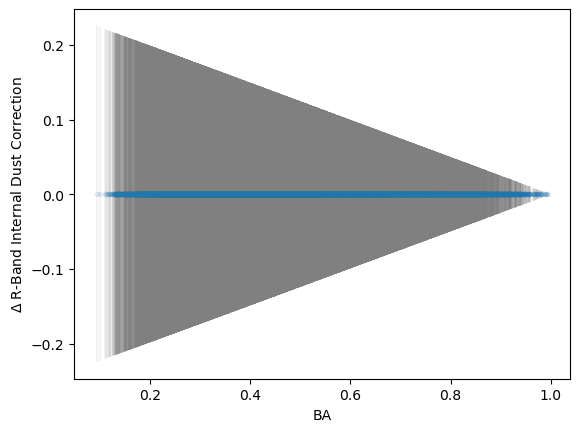

In [64]:
plt.errorbar(x=SGA_TF['BA'], y= (internalDust_corr_r_nok - internalDust_corr_r_k), 
             yerr=np.sqrt(internalDust_corr_err_r_k**2 + internalDust_corr_err_r_nok**2),
             fmt='.', ecolor='grey', alpha=0.1)
plt.xlabel('BA')
plt.ylabel(r'$\Delta$ R-Band Internal Dust Correction')

Text(0, 0.5, '$\\Delta$ R-Band Internal Dust Correction')

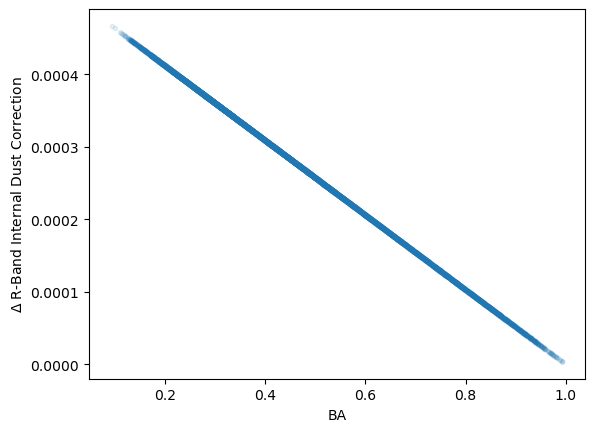

In [65]:
#### Zoomed in version:

plt.errorbar(x=SGA_TF['BA'], y= (internalDust_corr_r_nok - internalDust_corr_r_k), 
             # yerr=np.sqrt(internalDust_corr_err_r_k**2 + internalDust_corr_err_r_nok**2),
             fmt='.', ecolor='grey', alpha=0.1)
plt.xlabel('BA')
plt.ylabel(r'$\Delta$ R-Band Internal Dust Correction')

Text(0, 0.5, '$\\Delta$ R-Band Internal Dust Correction')

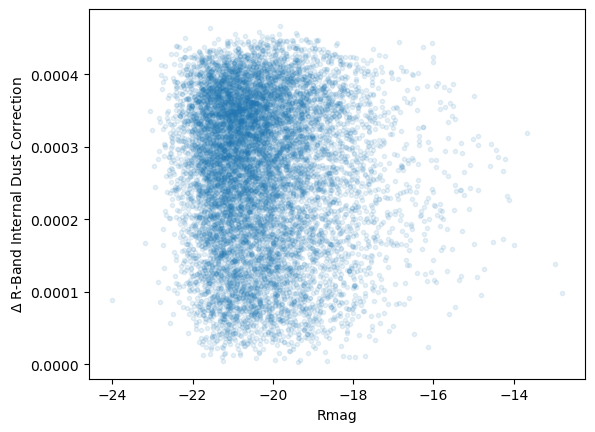

In [76]:
#### Zoomed in version:

plt.errorbar(x=SGA_TF['R_ABSMAG_SB26_K'], y= (internalDust_corr_r_nok - internalDust_corr_r_k), 
             # yerr=np.sqrt(internalDust_corr_err_r_k**2 + internalDust_corr_err_r_nok**2),
             fmt='.', ecolor='grey', alpha=0.1)
plt.xlabel('Rmag')
plt.ylabel(r'$\Delta$ R-Band Internal Dust Correction')

## See if there is a redshift evolution when we compare the two cases

In [28]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

Text(0, 0.5, '$\\Delta$ ZP')

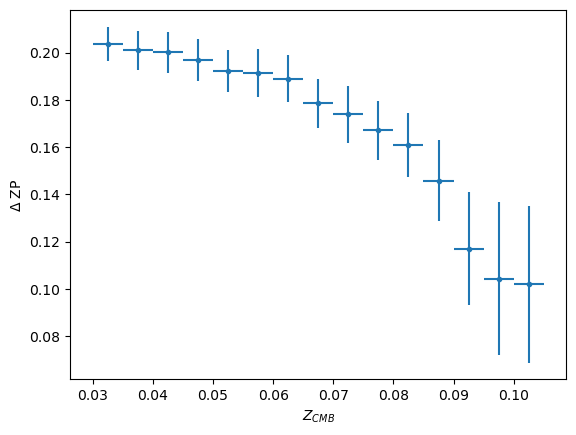

In [31]:
plt.errorbar(x=zc, xerr= dz*0.5, y= (ZP_nok - ZP_k), yerr= (ZP_err_k + ZP_err_nok), fmt='.')
plt.xlabel(r'$Z_{CMB}$')
plt.ylabel(r'$\Delta$ ZP')

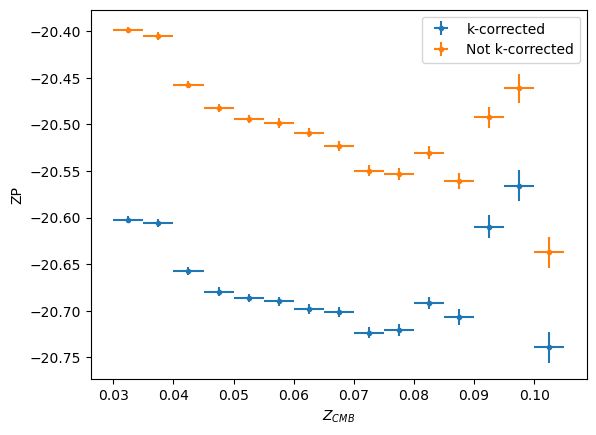

In [33]:
plt.errorbar(x=zc, xerr= dz*0.5, y= ZP_k, yerr= ZP_err_k, fmt='.', label='k-corrected')
plt.errorbar(x=zc, xerr= dz*0.5, y= ZP_nok, yerr= ZP_err_nok, fmt='.', label='Not k-corrected')
plt.xlabel(r'$Z_{CMB}$')
plt.ylabel(r'ZP')
plt.legend()